## Identify matches between the SWS/CASSIS datasets.

In [97]:
import astropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swsnet

from astropy.coordinates import SkyCoord
from concurrent.futures import ProcessPoolExecutor

In [2]:
def get_ang_sep(ra1, dec1, ra2, dec2):
    """
    Calculate the angular distance between two coordinates.

    Parameters
    ----------
    ra1 : float, array
        Right ascension of the first object in degrees.
    dec1 : float, array
        Declination of the first object in degrees.
    ra2 : float, array
        Right ascension of the second object in degrees.
    dec2 : float, array
        Declination of the second object in degrees.
    Returns
    -------
    Angle : float, array
        The angular distance in DEGREES between the first
        and second coordinate in the sky.

    """
    
    delt_lon = (ra1 - ra2)*np.pi/180.
    delt_lat = (dec1 - dec2)*np.pi/180.
    # Haversine formula
    dist = 2.0*np.arcsin( np.sqrt( np.sin(delt_lat/2.0)**2 + \
         np.cos(dec1*np.pi/180.)*np.cos(dec2*np.pi/180.)*np.sin(delt_lon/2.0)**2 ) )  

    ang_sep = dist/np.pi*180.
     
    return ang_sep

In [49]:
def get_matches(in_tuple):

    global czip
    global c_aor
    global s_tdt
    
    sindex, sra, sdec = in_tuple
    match_list = []
    
    for index, value in enumerate(czip):
        cindex, cra, cdec = value
        ang_sep = get_ang_sep(sra, sdec, cra, cdec)
        if ang_sep*3600 <= 30:
            positive_match = c_aor[cindex], s_tdt[sindex], ang_sep*3600, cindex, sindex
            match_list.append(positive_match)
    
    if match_list:
        return match_list
    else:
        return None

In [50]:
cass = pd.read_pickle('cassis/metadata.pkl')
sws = pd.read_pickle('isosws_atlas/metadata.pkl')

cra = cass.ra.values
cdec = cass.dec.values

sra = sws.ra.values
sdec = sws.dec.values

c_aor = cass.aorkey.values
s_tdt = sws.tdt.values

Array containing all possible combinations:

In [51]:
czip = []
szip = []

global czip
global c_aor
global s_tdt

for cindex, cvalue in enumerate(cra):
    czip.append((cindex, cra[cindex], cdec[cindex]))
    
for sindex, svalue in enumerate(sra):
    szip.append((sindex, sra[sindex], sdec[sindex]))    

In [52]:
len(czip), len(szip)

(6732, 1235)

### Use parallelization to calculate.

In [53]:
pool = ProcessPoolExecutor(max_workers=14)
results = list(pool.map(get_matches, szip))

In [90]:
def clean(array):
    
    cleaned_array = []
    array_remove_nones = [x for x in array if x is not None]
    
    for entry in array_remove_nones:
        if len(entry) == 1:
            cleaned_array.append(entry[0])
        else:
            for subentry in entry:
                cleaned_array.append(subentry)
                
    return np.array(cleaned_array)

In [91]:
cleaned = clean(results)

In [101]:
# aor, tdt, ang_sep (''), cassis_index, sws_index
cleaned

array([['21787648', '28501420', '13.801969580651912', '3428', '5'],
       ['21788416', '23200502', '9.683969511351991', '3431', '25'],
       ['10440704', '42500402', '12.890780337495183', '74', '29'],
       ...,
       ['21887488', '26301659', '7.8281940464130555', '3608', '1182'],
       ['3855616', '16700767', '10.539486328421072', '5988', '1183'],
       ['22268160', '24800307', '8.102067621399753', '4017', '1218']],
      dtype='<U18')

In [93]:
cleaned.shape

(507, 5)

In [95]:
ang_seps = cleaned.T[2].astype(float)

Text(0,0.5,'counts')

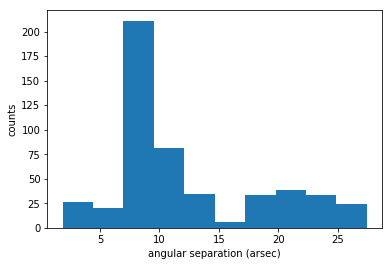

In [100]:
plt.hist(ang_seps);
plt.xlabel('angular separation (arsec)')
plt.ylabel('counts')